# Using Otsu's method and slope data to classify water area

### Flowchart

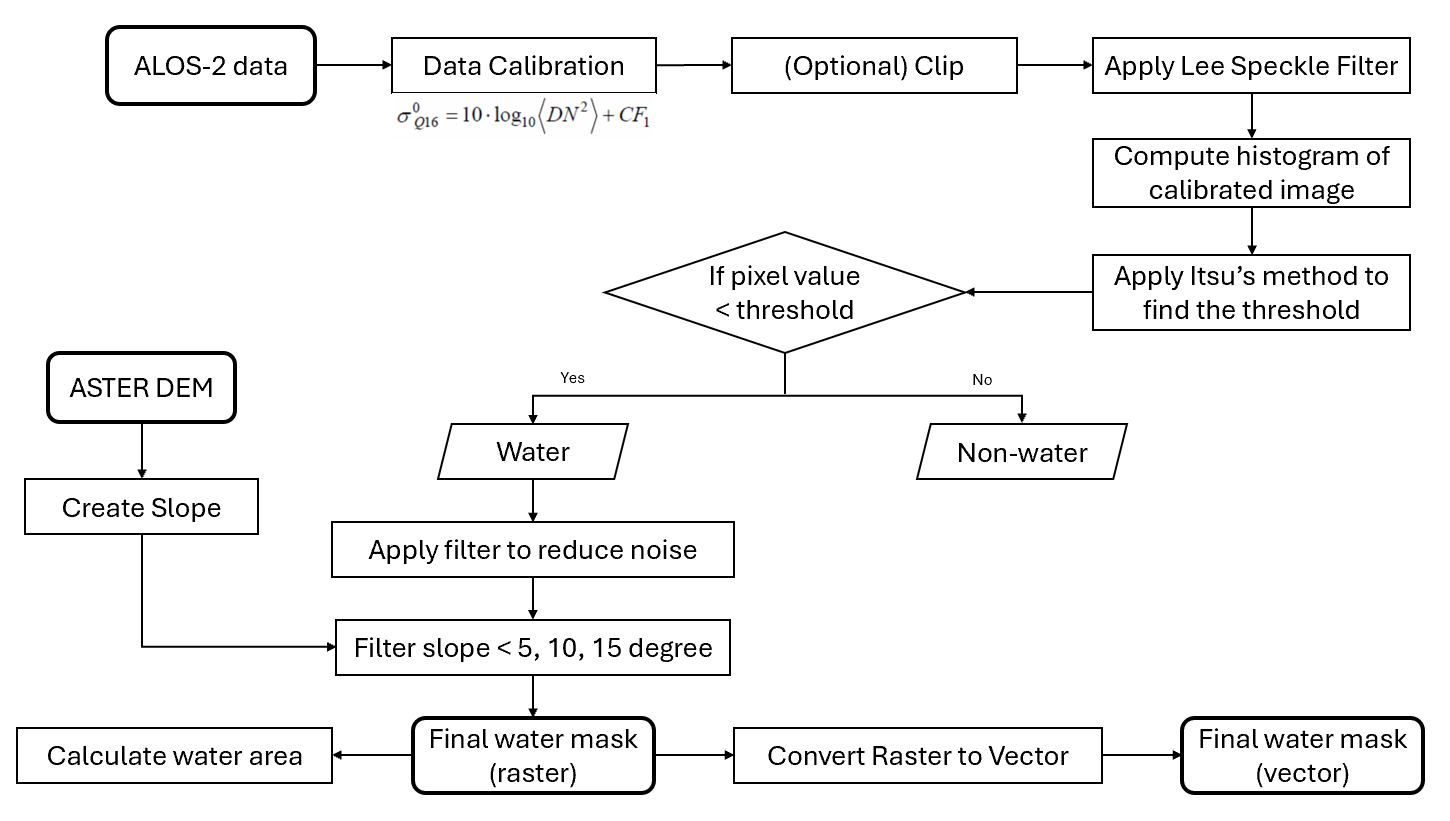

In this study, we will use the ALOS-2 data from JAXA. However, this hands-on use the sample data that downloaded from JAXA's website.

After got the data, apply Radiometric calibration factors to convert digital number to backscatter value.

**NOTE**: Radiometric calibration is crucial for converting ALOS-2 SAR data into physically meaningful values (like backscatter) that accurately represent the reflectivity of the Earth's surface. It ensures that the data is corrected for sensor biases, comparable across different sensors or acquisition times, and suitable for detailed analysis like environmental monitoring, land use classification, and disaster management.

### Data calibration
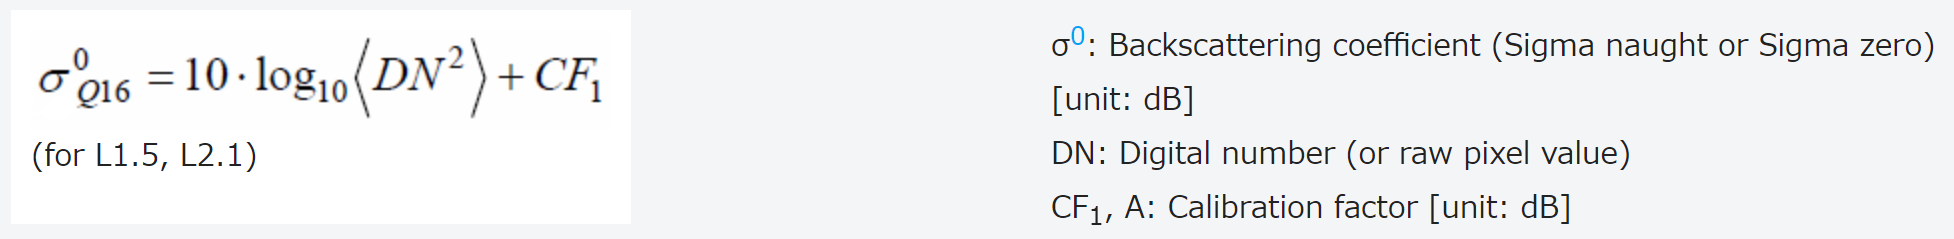
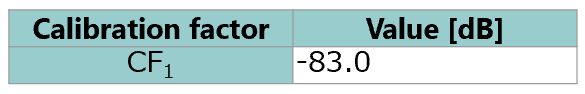

- You can use this formula in Raster calculator in **QGIS** to calibrate the data using formula:

  (20*log10(ALOS-2 data))-83

##### NOTE: In this hands-on, we use calibrated data as an input data.

In [1]:
pip install rasterio

  Using cached rasterio-1.4.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.0 kB)
  Using cached affine-2.4.0-py3-none-any.whl.metadata (4.0 kB)
  Using cached cligj-0.7.2-py3-none-any.whl.metadata (5.0 kB)
  Using cached click_plugins-1.1.1-py2.py3-none-any.whl.metadata (6.4 kB)
Using cached rasterio-1.4.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (22.2 MB)
Using cached cligj-0.7.2-py3-none-any.whl (7.1 kB)
Using cached affine-2.4.0-py3-none-any.whl (15 kB)
Using cached click_plugins-1.1.1-py2.py3-none-any.whl (7.5 kB)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install geopandas

In [ ]:
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio.mask
from scipy.ndimage import uniform_filter

## Load the ALOS-2 image

In [2]:
# Load the ALOS-2 image
clipped_image_path = '/home/jovyan/shared/Arissara/ALOS-2/ALOS_2_180414-clipped.tif'

## Visualize the original full image

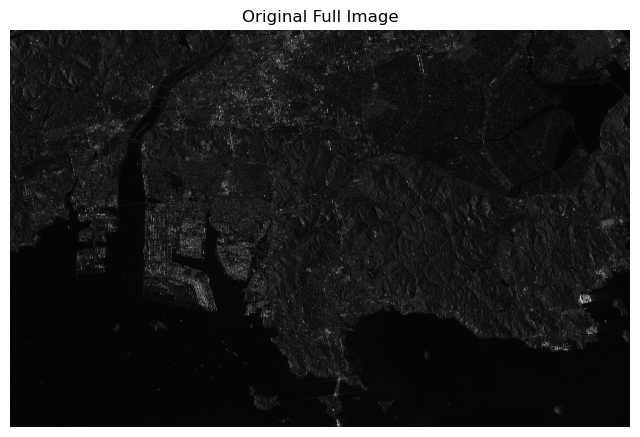

In [3]:
# Step to visualize the original full image
with rasterio.open(clipped_image_path) as src:
    clipped_original_image = src.read(1)  # Read the first band for visualization
    profile = src.profile  # Keep the profile for exporting

def visualize_original(image):
    plt.figure(figsize=(8, 8))
    plt.imshow(image, cmap='gray')
    plt.title('Original Full Image')
    plt.axis('off')
    plt.show()

# Visualize the original full image
visualize_original(clipped_original_image)

## Apply the calibration expression

In [4]:
# Apply the calibration formula to the clipped image
calibrated_image = (20 * np.log10(clipped_original_image)) - 83

/tmp/ipykernel_142/1889648727.py:2: RuntimeWarning: divide by zero encountered in log10
  calibrated_image = (20 * np.log10(clipped_original_image)) - 83


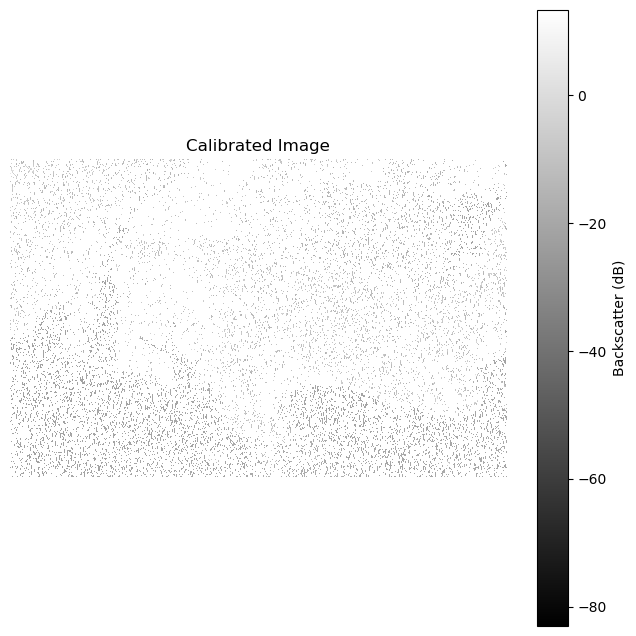

In [5]:
# Function to visualize the calibrated image
def visualize_calibrated(image):
    plt.figure(figsize=(8, 8))
    plt.imshow(image, cmap='gray')
    plt.title('Calibrated Image')
    plt.colorbar(label='Backscatter (dB)')
    plt.axis('off')
    plt.show()

# Visualize the calibrated image
visualize_calibrated(calibrated_image)

In [9]:
# Export the calibrated image
export_path = '/home/jovyan/shared/Arissara/ALOS-2/hands-on/pre-calib_ALOS_2_180414-clipped.tif'

# Update profile for float32 data type
profile.update(dtype=rasterio.float32)

# Save the calibrated image as a GeoTIFF
with rasterio.open(export_path, 'w', **profile) as dst:
    dst.write(calibrated_image.astype(rasterio.float32), 1)  # Save the image as float32

However, the area of interest that we use in this case is **cover mountain area**. In mountainous areas, incorporating slope data with Otsu's method to classify water areas is essential due to the complex terrain. Here's why this combination is important:

#### 1. Impact of Terrain on Water Detection

 - Otsu's Method is an unsupervised thresholding technique often used to separate foreground (water) from background (non-water) in images. It works well in flat areas where pixel intensity or backscatter from water bodies is distinct.
 - However, in mountainous regions, the varying topography causes different radar backscatter or reflectance properties, especially from steep slopes, which can sometimes be mistaken for water or cause false positives.

#### 2. Reduction of False Positives
 - Steep Slopes Mimicking Water: In mountainous areas, slopes facing away from the sensor may appear darker due to shadowing effects, which might be misclassified as water in radar or optical images. By integrating slope data (derived from a Digital Elevation Model or DEM), you can identify areas where steep slopes are likely to create shadowing or dark areas in the image that could be confused with water.
 - Slope-based Exclusion: By filtering out steep regions using slope data before or after applying Otsu's method, you can significantly reduce the chances of misclassifying shadowed areas or steep terrain as water bodies.

#### 3. Improved Classification Accuracy
 - Water in Low-Slope Areas: Water bodies are typically found in flatter, low-slope areas like valleys or basins. Including slope data allows you to focus your classification on these low-slope areas where water is more likely to be present.
 - Accurate Thresholding: By considering slope, Otsu's method can be adapted or post-processed to focus on areas where the backscatter or intensity variation truly indicates water, improving classification accuracy in mountainous regions.

#### Workflow:

 - Generate Slope Map: Use a Digital Elevation Model (DEM) to create a slope map.
 - Apply Otsu's Method: Perform Otsu’s thresholding on the satellite data to classify potential water areas based on pixel intensity or backscatter.
 - Apply Slope Data: Exclude or refine classifications in areas with high slope values, filtering out potential misclassifications caused by shadows or steep terrain.

#### Conclusion
Using slope data in conjunction with Otsu’s method helps improve water classification in mountainous areas by reducing the impact of terrain-induced shadows and focusing on flat, water-prone regions. This ensures more reliable and accurate identification of water bodies in complex topographies.

#### Reference

 - [Otsu's Threshold Method on IEEE Xplore](https://ieeexplore.ieee.org/document/4310076)

Research on terrain effects on water classification can be found in:

 - [McFeeters NDWI Paper](https://www.tandfonline.com/doi/abs/10.1080/01431169608948714)
 - [Tucker's Paper on ScienceDirect](https://www.sciencedirect.com/science/article/abs/pii/0034425779900130)

### Create slope from DEM

In [2]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt

In [3]:
# Load the DEM
dem_path = '/home/jovyan/shared/Arissara/ALOS-2/clipped_ASTGTMV003_N34E133_dem.tif'  # Update with the path to your DEM
with rasterio.open(dem_path) as dem_src:
    dem = dem_src.read(1)  # Read the first (and likely only) band from the DEM
    profile = dem_src.profile
    transform = dem_src.transform

In [4]:
# Calculate the pixel size from the DEM's transform
# transform[0] gives the pixel width (x resolution)
# transform[4] gives the pixel height (y resolution, typically negative)
pixel_size_x = transform[0]
pixel_size_y = -transform[4]  # Negative as it’s typically negative in a geotransform

# Compute the slope using numpy gradient (which calculates the first derivative)
dem = np.nan_to_num(dem)  # Handling NaN values if any
gradient_y, gradient_x = np.gradient(dem, pixel_size_y, pixel_size_x)

# Calculate the slope in degrees
slope = np.arctan(np.sqrt(gradient_x**2 + gradient_y**2)) * (180 / np.pi)

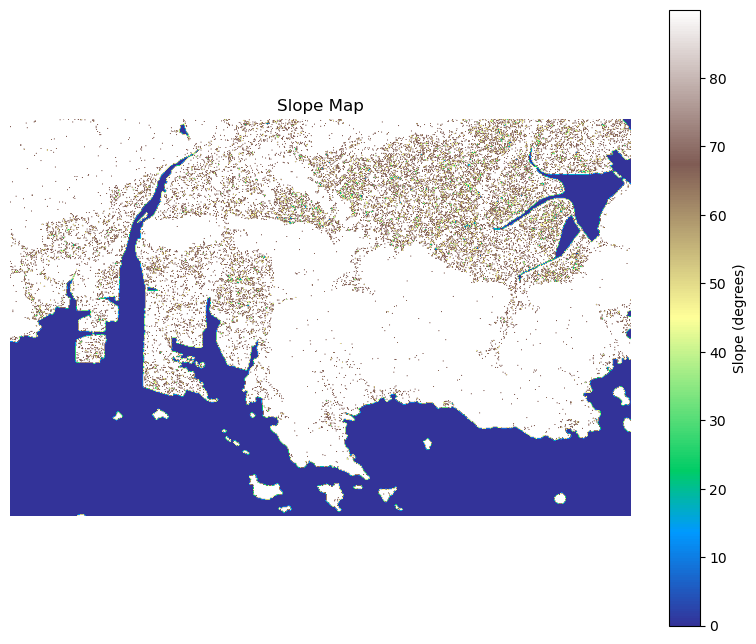

In [5]:
# Visualize the slope
plt.figure(figsize=(10, 8))
plt.imshow(slope, cmap='terrain')
plt.colorbar(label='Slope (degrees)')
plt.title('Slope Map')
plt.axis('off')
plt.show()

In [6]:
# Optionally, you can export the slope map as a GeoTIFF
output_slope_path = '/home/jovyan/shared/Arissara/ALOS-2/hands-on/slope.tif'  # Set the output path
profile.update(dtype=rasterio.float32, count=1)  # Update profile to match slope data

with rasterio.open(output_slope_path, 'w', **profile) as dst:
    dst.write(slope.astype(rasterio.float32), 1)

## Classify water area

In [1]:
import numpy as np
import rasterio
from rasterio import plot
import matplotlib.pyplot as plt
from skimage import filters
from skimage.filters import threshold_otsu
from skimage.morphology import disk
from skimage.restoration import denoise_tv_chambolle

In [2]:
# Load the ALOS-2 image
image_path = '/home/jovyan/shared/Arissara/ALOS-2/calibration/pre-calib_ALOS_2_180414-clipped.tif'

In [3]:
# Load the ALOS-2 image
with rasterio.open(image_path) as src:
    image = src.read(1)  # Reading the first band (HH or HV)
    profile = src.profile
    transform = src.transform
    bounds = src.bounds

### [Lee filter](https://www.researchgate.net/publication/239659062_Speckle_filtering_of_synthetic_aperture_radar_images_A_Review)

The **Lee Speckle Filter** is a technique used to reduce speckle noise in SAR (Synthetic Aperture Radar) imagery. Speckle noise is a granular noise that naturally occurs in SAR images due to the coherent nature of radar systems, where each pixel contains multiple scatterers contributing to the same radar return signal. This noise degrades the quality of the image and makes interpretation or further analysis difficult.

#### How the **Lee Filter** Works:
- The **Lee Filter** is an adaptive filter that assumes the underlying image has a piecewise-constant signal (i.e., smooth surfaces, separated by edges) and that speckle noise is multiplicative. 
- It works by calculating the local statistics (mean and variance) over a moving window of the image.
- The filter preserves the edges and other significant features while smoothing homogeneous areas. It adapts based on the local variance of the image pixels: areas of low variance (homogeneous regions) are heavily smoothed, while areas of high variance (edges, boundaries) are less smoothed.#

### Why Use the **Lee Speckle Filter** on ALOS PALSAR-2 Data?
ALOS PALSAR-2 is a type of SAR sensor that generates radar data, often affected by speckle noise. Applying the Lee Speckle Filter on ALOS PALSAR-2 data helps in:
1. **Noise Reduction:** It reduces speckle noise while preserving important image details such as edges.
2. **Improved Interpretation:** Cleaned images allow for better visual interpretation and feature extraction.
3. **Better Analysis:** For quantitative analysis like classification, change detection, or biomass estimation, reduced speckle helps improve the accuracy oh the link above.

### References:
 - [Digital Image Enhancement and Noise Filtering by Use of Local Statistics](https://ieeexplore.ieee.org/document/4766994?rsource=https:%2F%2Flinks.esri.com%2FNoiseFilteringUsingLocalStats)

 - Sentinel Online SAR Toolbox: [Speckle Filtering](https://sentinel.esa.int/web/sentinel/toolboxes/sentinel-1/speckle-filtering)

The provided code below implements a **Lee filter**, which is commonly used to reduce speckle noise in Synthetic Aperture Radar (SAR) images. It works by processing each pixel in the image using a sliding window (of size defined by `window_size`). For each window, it calculates the local mean and variance to determine a damping factor \( k \), which controls how much smoothing is applied to the pixel. The filter smooths homogeneous areas (low variance) while preserving detail in regions with high variance (like edges). The resulting `filtered_image` is a noise-reduced version of the input image.

In [4]:
# Define a Lee filter function (as before)
def lee_filter(image, window_size=3):
    image = np.nan_to_num(image)  # Handle NaN values
    filtered_image = np.zeros_like(image)
    half_window = window_size // 2

    for i in range(half_window, image.shape[0] - half_window):
        for j in range(half_window, image.shape[1] - half_window):
            window = image[i-half_window:i+half_window+1, j-half_window:j+half_window+1]
            mean = np.mean(window)
            variance = np.var(window)
            local_variance = np.var(window)
            
            if local_variance > 0:
                k = local_variance / (local_variance + variance)
            else:
                k = 0
            
            filtered_image[i, j] = mean + k * (image[i, j] - mean)

    return filtered_image

In [5]:
# Apply Lee filter to the SAR image
filtered_image = lee_filter(image, window_size=5)

/opt/conda/lib/python3.11/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/tmp/ipykernel_346/495975076.py:15: RuntimeWarning: invalid value encountered in scalar divide
  k = local_variance / (local_variance + variance)
/opt/conda/lib/python3.11/site-packages/numpy/core/_methods.py:181: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/opt/conda/lib/python3.11/site-packages/numpy/core/_methods.py:215: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


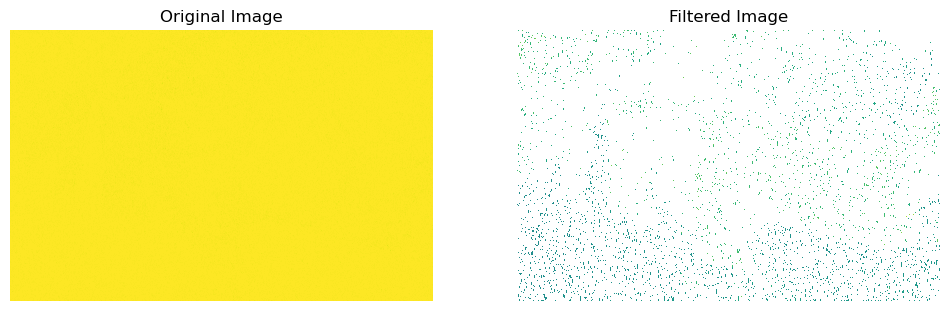

In [6]:
# Visualize the images
plt.figure(figsize=(12, 8))

# Display the original image
plt.subplot(1, 2, 1)
plt.imshow(image, extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])
plt.title('Original Image')
plt.axis('off')

# Display the filtered image
plt.subplot(1, 2, 2)
plt.imshow(filtered_image, extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])
plt.title('Filtered Image')
plt.axis('off')

plt.show()

Because original image cannot see anything in the image. Thus, we apply contrast stretching before visualizing an image to enhance its visibility and bring out important details. In many images, especially in scientific or satellite data (like SAR images), the pixel values may have a narrow range (i.e., the values are mostly concentrated in a specific range of intensities). If this raw data is visualized without modification, it may appear very dark, washed out, or lacking contrast, making it hard to interpret.

By stretching the pixel values between a defined lower and upper percentile (e.g., the 2nd and 98th percentiles), the intensity range of the image is expanded. This process:

 - Increases Contrast: Brings out the finer details by spreading the intensities over the full display range (e.g., 0 to 1), so features that were previously hard to see become more visible.
 - Improves Visual Interpretation: Makes the image easier to interpret by enhancing darker areas and reducing overexposure in bright areas.

In the code below:

 - Lower and Upper Percentiles: The lower_percentile (2%) and upper_percentile (98%) are used to ignore extreme dark or bright outliers and focus on the main intensity range of the image.
 - Stretching Formula: The image is linearly stretched using (image - lower) / (upper - lower) to map the intensity values into the [0, 1] range.
 - np.clip: This ensures all pixel values remain between 0 and 1 after stretching, avoiding negative values or those exceeding 1.

This step helps make both the original and filtered images easier to analyze visually.

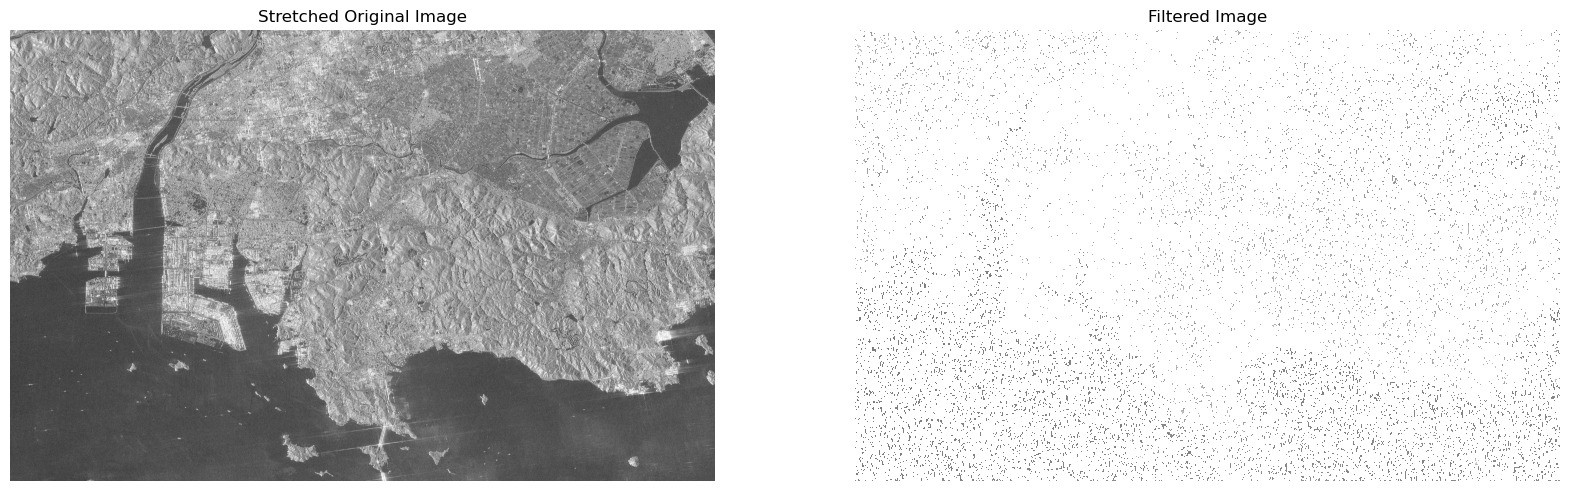

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Define a function to apply contrast stretching
def contrast_stretching(image, lower_percentile=2, upper_percentile=98):
    # Calculate lower and upper percentiles
    lower = np.percentile(image, lower_percentile)
    upper = np.percentile(image, upper_percentile)
    
    # Stretching
    stretched_image = (image - lower) / (upper - lower)
    stretched_image = np.clip(stretched_image, 0, 1)  # Ensure values are between 0 and 1
    return stretched_image

# Apply contrast stretching to the original image
stretched_image = contrast_stretching(image)

# Visualize the images
plt.figure(figsize=(20, 10))

# Display the original stretched image
plt.subplot(1, 2, 1)
plt.imshow(stretched_image, cmap='gray')  # Add a colormap if necessary
plt.title('Stretched Original Image')
plt.axis('off')

# Display the filtered image
plt.subplot(1, 2, 2)
plt.imshow(filtered_image, cmap='gray')
plt.title('Filtered Image')
plt.axis('off')

plt.show()

This code computes and visualizes the histogram of the image, which represents the distribution of pixel intensities. It uses `numpy.histogram` to calculate the histogram with 255 bins, corresponding to pixel intensities in the image. The **mean** and **variance** of the pixel values are computed to help describe the distribution. The plot includes vertical dashed lines at the mean (red) and one standard deviation (green) above and below the mean, providing visual markers for the central tendency and spread of the data. The plot is labeled with these values for better interpretation, with titles and axis labels to enhance clarity. This visualization helps assess the overall contrast and intensity distribution in the image.

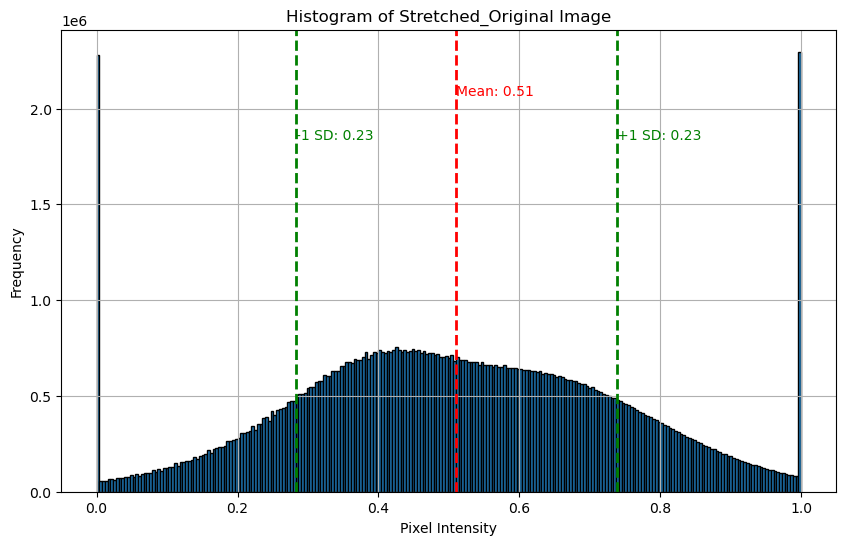

In [8]:
# Compute the histogram for the original image
hist, bin_edges = np.histogram(stretched_image, bins=255)
mean_val = np.mean(stretched_image)
var_val = np.var(stretched_image)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), edgecolor='black', align='edge')

# Annotate the mean and variance on the plot
plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=2)
plt.text(mean_val, max(hist) * 0.9, f'Mean: {mean_val:.2f}', color='red')

plt.axvline(mean_val + np.sqrt(var_val), color='green', linestyle='dashed', linewidth=2)
plt.axvline(mean_val - np.sqrt(var_val), color='green', linestyle='dashed', linewidth=2)
plt.text(mean_val + np.sqrt(var_val), max(hist) * 0.8, f'+1 SD: {np.sqrt(var_val):.2f}', color='green')
plt.text(mean_val - np.sqrt(var_val), max(hist) * 0.8, f'-1 SD: {np.sqrt(var_val):.2f}', color='green')

# Add titles and labels
plt.title('Histogram of Stretched_Original Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.grid(True)

# Show the plot
plt.show()

In [9]:
# Compute the histogram for the Filtered image
hist, bin_edges = np.histogram(filtered_image, bins=255)
mean_val = np.mean(filtered_image)
var_val = np.var(filtered_image)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), edgecolor='black', align='edge')

# Annotate the mean and variance on the plot
plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=2)
plt.text(mean_val, max(hist) * 0.9, f'Mean: {mean_val:.2f}', color='red')

plt.axvline(mean_val + np.sqrt(var_val), color='green', linestyle='dashed', linewidth=2)
plt.axvline(mean_val - np.sqrt(var_val), color='green', linestyle='dashed', linewidth=2)
plt.text(mean_val + np.sqrt(var_val), max(hist) * 0.8, f'+1 SD: {np.sqrt(var_val):.2f}', color='green')
plt.text(mean_val - np.sqrt(var_val), max(hist) * 0.8, f'-1 SD: {np.sqrt(var_val):.2f}', color='green')

# Add titles and labels
plt.title('Histogram of Filtered Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.grid(True)

# Show the plot
plt.show()

ValueError: autodetected range of [nan, nan] is not finite

We should ensure that the image does not contain NaN, infinite (inf), or negative infinite (-inf) values before computing the histogram for several reasons:

1. NaN and Inf Values Are Undefined in Histograms:
NaN (Not a Number) and inf (infinite) values are not valid numerical values for most statistical computations, including histograms. A histogram requires valid, finite numbers to count occurrences in specific ranges (bins).
If a histogram encounters NaN or inf values, it could cause errors or produce meaningless results because these values don't belong to any meaningful range of real numbers.
2. Impact on Histogram Accuracy:
If NaN or inf values are not handled, the computed histogram would be inaccurate, as the presence of these invalid values can distort the representation of the data. It might either skew the distribution or lead to missing data points in the histogram.
3. Prevention of Errors in Visualization:
Histogram plotting libraries (like those in matplotlib or numpy) typically expect clean numerical arrays. NaN, inf, or -inf values can trigger errors, causing the code to crash or preventing the histogram from being generated.
4. Ensuring Data Consistency:
Replacing NaN, inf, and -inf values with valid numbers (in this case, 0) ensures consistency in the data. This replacement allows the histogram computation to proceed smoothly without interruptions, resulting in a histogram that accurately reflects the meaningful parts of the data.

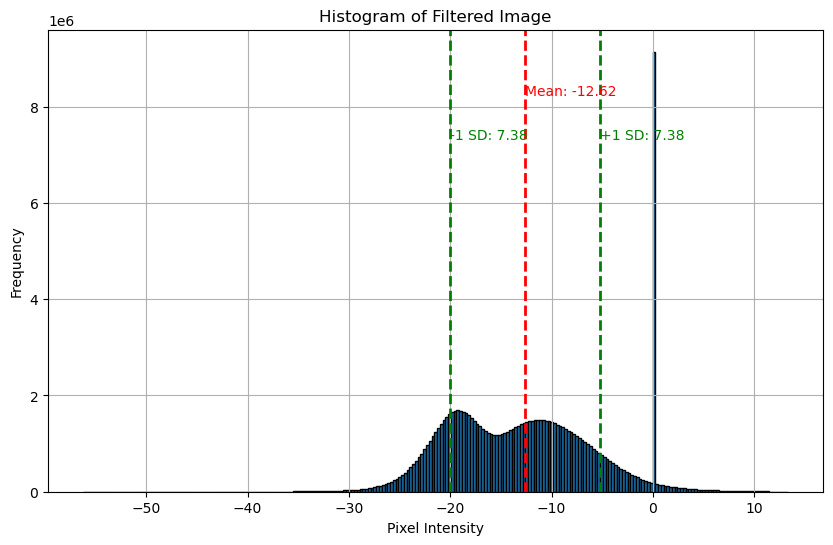

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure the filtered_image does not contain NaN, inf, or -inf values
filtered_image_clean = np.nan_to_num(filtered_image, nan=0, posinf=0, neginf=0)

# Compute the histogram for the cleaned image
hist, bin_edges = np.histogram(filtered_image_clean, bins=255)
mean_val = np.mean(filtered_image_clean)
var_val = np.var(filtered_image_clean)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), edgecolor='black', align='edge')

# Annotate the mean and variance on the plot
plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=2)
plt.text(mean_val, max(hist) * 0.9, f'Mean: {mean_val:.2f}', color='red')

plt.axvline(mean_val + np.sqrt(var_val), color='green', linestyle='dashed', linewidth=2)
plt.axvline(mean_val - np.sqrt(var_val), color='green', linestyle='dashed', linewidth=2)
plt.text(mean_val + np.sqrt(var_val), max(hist) * 0.8, f'+1 SD: {np.sqrt(var_val):.2f}', color='green')
plt.text(mean_val - np.sqrt(var_val), max(hist) * 0.8, f'-1 SD: {np.sqrt(var_val):.2f}', color='green')

# Add titles and labels
plt.title('Histogram of Filtered Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.grid(True)

# Show the plot
plt.show()


In [11]:
from skimage.filters import threshold_otsu

threshold = threshold_otsu(filtered_image_clean)
print(f"Otsu's Threshold for SAR Image: {threshold}")

Otsu's Threshold for SAR Image: -12.335062026977539


In [12]:
# Create the binary water mask
water_mask = filtered_image_clean < threshold

In [13]:
# Load the slope
slope_path = '/home/jovyan/shared/Arissara/ALOS-2/hands-on/slope.tif'  # Update this with the path to the slope file

In [14]:
# Load the slope raster
with rasterio.open(slope_path) as slope_src:
    slope = slope_src.read(1)  # Read the first band of slope data
    slope_profile = slope_src.profile

The step below use a **median filter** to remove noise from the water mask because it is highly effective at preserving edges while removing small, isolated noise artifacts.
U using a **3x3 window** in the median filter, small noisk is smoothed out, while larger features, like water bodies, remain intact, ensuring a cleaner and more accurate representation of the water areas.

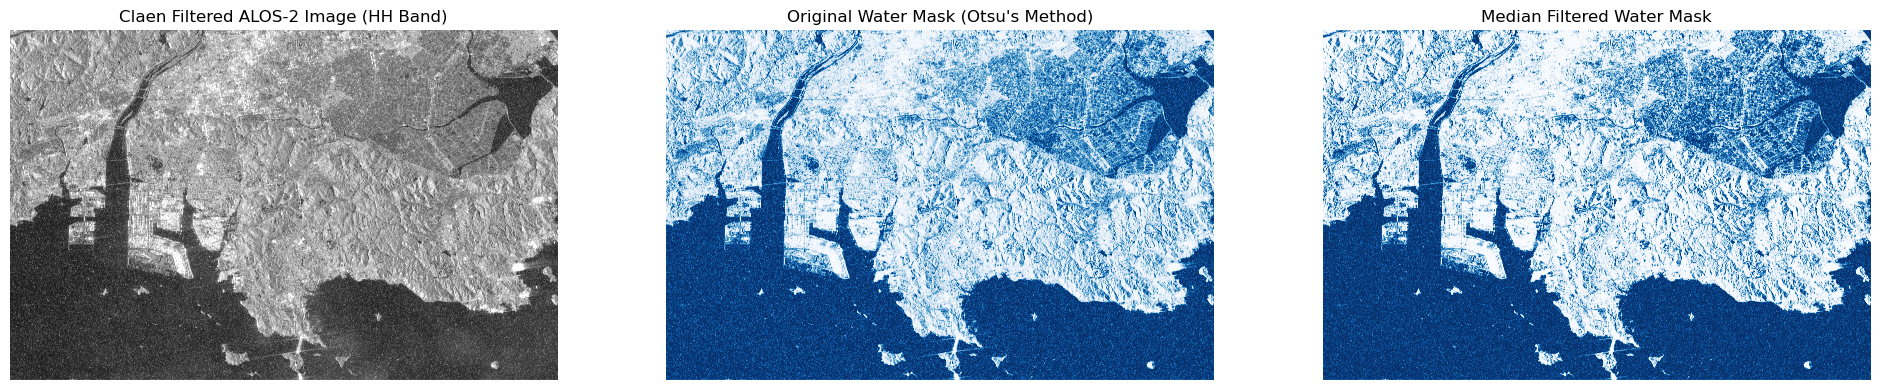

In [15]:
import numpy as np
import rasterio
from rasterio import plot
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from skimage.morphology import disk
from scipy.ndimage import median_filter  # Import the median_filter from scipy.ndimage

# Apply the median filter to remove noise from the water mask
# Define the size of the median filter (footprint size equivalent to disk radius 2)
water_mask_filtered = median_filter(water_mask, size=3)  # Use size 3 for a 3x3 window

# Visualize the filtered image, water mask, and median-filtered mask
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

# Display filtered ALOS-2 image
vmin = np.percentile(filtered_image_clean, 2)
vmax = np.percentile(filtered_image_clean, 98)
ax1.imshow(filtered_image_clean, cmap='gray', vmin=vmin, vmax=vmax)
ax1.set_title('Claen Filtered ALOS-2 Image (HH Band)')
ax1.axis('off')

# Display the original water mask
ax2.imshow(water_mask, cmap='Blues')
ax2.set_title('Original Water Mask (Otsu\'s Method)')
ax2.axis('off')

# Display the median-filtered water mask
ax3.imshow(water_mask_filtered, cmap='Blues')
ax3.set_title('Median Filtered Water Mask')
ax3.axis('off')


plt.show()


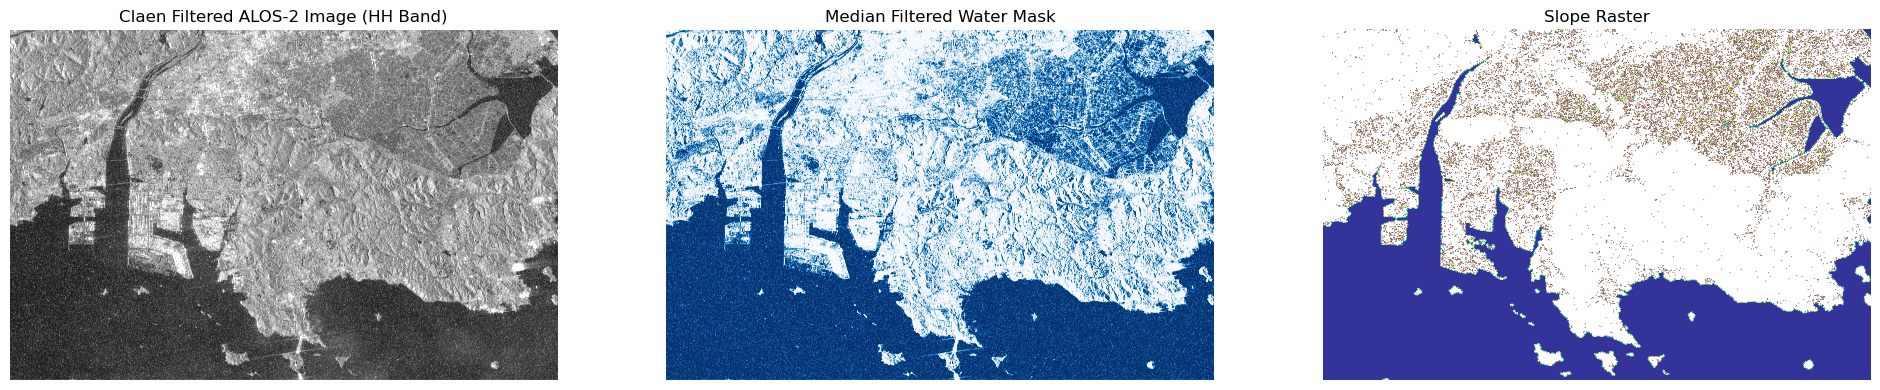

In [16]:
# Visualize the filtered image, water mask, and slope data
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

# Display filtered ALOS-2 image
vmin = np.percentile(filtered_image_clean, 2)
vmax = np.percentile(filtered_image_clean, 98)
ax1.imshow(filtered_image_clean, cmap='gray', vmin=vmin, vmax=vmax)
ax1.set_title('Claen Filtered ALOS-2 Image (HH Band)')
ax1.axis('off')

# Display the water mask
ax2.imshow(water_mask_filtered, cmap='Blues')
ax2.set_title('Median Filtered Water Mask')
ax2.axis('off')

# Display the slope data
ax3.imshow(slope, cmap='terrain')
ax3.set_title('Slope Raster')
ax3.axis('off')

plt.show()


### Slope 5 degree

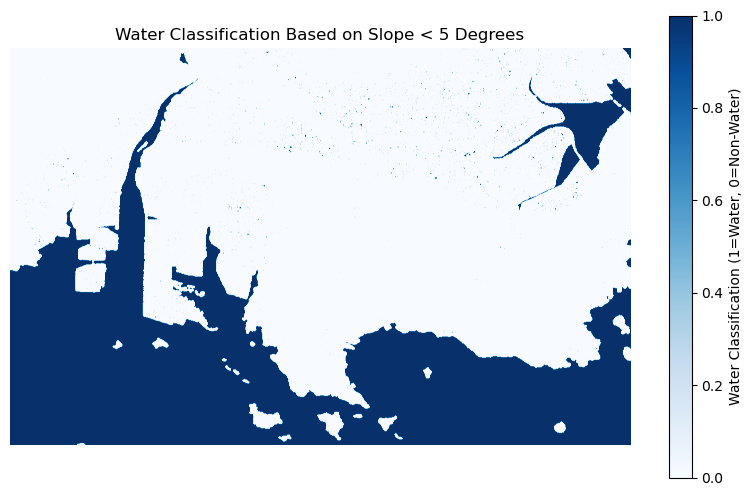

In [17]:
import numpy as np
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt

def resample_raster(source_raster, target_raster_shape, target_transform, target_crs):
    # Create an empty array for the resampled slope data
    resampled_raster = np.empty(target_raster_shape, dtype=source_raster.dtype)
    
    # Perform the reprojection/resampling
    with rasterio.Env():
        reproject(
            source=source_raster,
            destination=resampled_raster,
            src_transform=slope_src.transform,
            src_crs=slope_src.crs,
            dst_transform=target_transform,
            dst_crs=target_crs,
            resampling=Resampling.bilinear  # You can choose other resampling methods (e.g., nearest, cubic)
        )
    
    return resampled_raster

# Resample the slope data to match the water mask dimensions
with rasterio.open(slope_path) as slope_src:
    slope_resampled = resample_raster(
        slope_src.read(1),  # The slope data (first band)
        water_mask.shape,  # Target shape (same as water_mask)
        transform,  # The transform of the water mask
        profile['crs']  # The CRS of the water mask
    )

# Classify based on slope threshold (<5 degrees for water, >=5 degrees for non-water)
water_classification = np.where(slope_resampled < 5, 1, 0)  # 1 for water, 0 for non-water

# Optionally, combine this classification with a water mask filter if you want to refine results
# water_mask_filtered = (water_mask == 1)  # Assuming water_mask is binary
# water_classification = np.where(water_mask_filtered, water_classification, np.nan)

# Plot the classified water and non-water areas
plt.figure(figsize=(10, 6))
plt.imshow(water_classification, cmap='Blues')  # Blue for water, white for non-water
plt.colorbar(label='Water Classification (1=Water, 0=Non-Water)')
plt.title('Water Classification Based on Slope < 5 Degrees')
plt.axis('off')
plt.show()

In [20]:
# Assuming roi is defined as a bounding box: (min_lon, min_lat, max_lon, max_lat)
roi = [133.6341032752386866, 34.4100997954243155, 133.9596877832316864, 34.6186143745820587]
##roi = [102.0000000000000000,0.0000000000000000, 103.0000000000000000,1.0000000000000000]

# Calculate the midpoint latitude of the ROI
latitude = (roi[1] + roi[3]) / 2  # (min_lat + max_lat) / 2

# Use the latitude to calculate the conversion factor from degrees to meters
meters_per_degree = 111320 * np.cos(np.radians(latitude))  # Adjust based on latitude

pixel_width_deg = abs(profile['transform'][0])
pixel_height_deg = abs(profile['transform'][4])

# Convert pixel dimensions from degrees to meters
pixel_width_m = pixel_width_deg * meters_per_degree
pixel_height_m = pixel_height_deg * meters_per_degree

# Calculate pixel area in square meters
pixel_area = pixel_width_m * pixel_height_m
print(f"Pixel area (in square meters): {pixel_area:.2f}")

# Calculate the area covered by water in hectares
water_area_ha = np.sum(water_classification5) * pixel_area / 10000  # convert to hectares
print(f'Water Area: {water_area_ha:.2f} hectares')

Pixel area (in square meters): 5.15
Water Area: 18787.70 hectares


In [19]:
import numpy as np
import rasterio
from rasterio.transform import from_origin

# Assuming slope_resampled, transform, and profile are already available from previous code

# Classify based on slope threshold (<5 degrees for water, >=5 degrees for non-water)
water_classification5 = np.where(slope_resampled < 5, 1, 0).astype(np.uint8)  # 1 for water, 0 for non-water, and set dtype to uint8

# Export the classified water data as a GeoTIFF
output_path = "/home/jovyan/shared/Arissara/ALOS-2/hands-on/test/5degree_water_classification.tif"

# Open a new file to write the GeoTIFF
with rasterio.open(
    output_path,
    'w',
    driver='GTiff',
    height=water_classification.shape[0],
    width=water_classification.shape[1],
    count=1,  # Number of bands
    dtype=water_classification.dtype,  # Ensure correct dtype
    crs=profile['crs'],  # Use the CRS from the original raster (this is critical for QGIS)
    transform=transform,  # Use the transform from the original raster
    compress='lzw',  # Optional: Compress to reduce file size, can be removed if not needed
    nodata=255  # Define nodata value, for areas without data, you can adjust this value as needed
) as dst:
    dst.write(water_classification, 1)  # Write the classification array to the first band
    dst.update_tags(1, description="Water classification (1=water, 0=non-water)")

print(f"Water classification has been exported to {output_path}")


Water classification has been exported to /home/jovyan/shared/Arissara/ALOS-2/hands-on/test/5degree_water_classification.tif


### Slope 10 degree

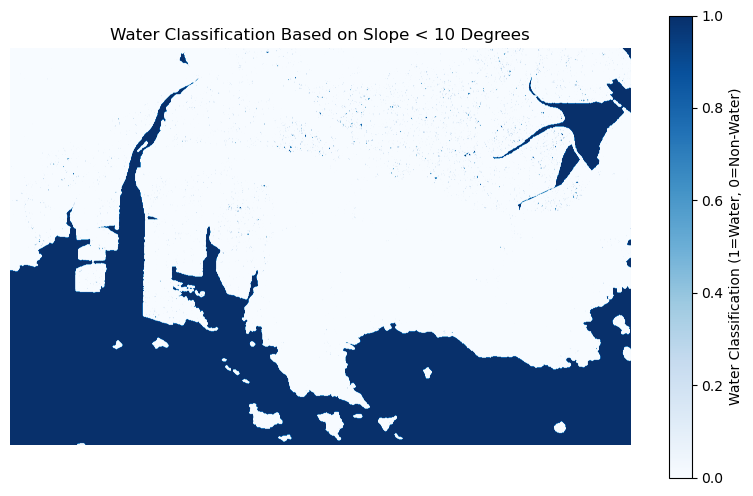

In [21]:
import numpy as np
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt

def resample_raster(source_raster, target_raster_shape, target_transform, target_crs):
    # Create an empty array for the resampled slope data
    resampled_raster = np.empty(target_raster_shape, dtype=source_raster.dtype)
    
    # Perform the reprojection/resampling
    with rasterio.Env():
        reproject(
            source=source_raster,
            destination=resampled_raster,
            src_transform=slope_src.transform,
            src_crs=slope_src.crs,
            dst_transform=target_transform,
            dst_crs=target_crs,
            resampling=Resampling.bilinear  # You can choose other resampling methods (e.g., nearest, cubic)
        )
    
    return resampled_raster

# Resample the slope data to match the water mask dimensions
with rasterio.open(slope_path) as slope_src:
    slope_resampled = resample_raster(
        slope_src.read(1),  # The slope data (first band)
        water_mask.shape,  # Target shape (same as water_mask)
        transform,  # The transform of the water mask
        profile['crs']  # The CRS of the water mask
    )

# Classify based on slope threshold (<10 degrees for water, >=10 degrees for non-water)
water_classification10 = np.where(slope_resampled < 10, 1, 0).astype(np.uint8)  # 1 for water, 0 for non-water, and set dtype to uint8

# Optionally, combine this classification with a water mask filter if you want to refine results
# water_mask_filtered = (water_mask == 1)  # Assuming water_mask is binary
# water_classification = np.where(water_mask_filtered, water_classification, np.nan)

# Plot the classified water and non-water areas
plt.figure(figsize=(10, 6))
plt.imshow(water_classification, cmap='Blues')  # Blue for water, white for non-water
plt.colorbar(label='Water Classification (1=Water, 0=Non-Water)')
plt.title('Water Classification Based on Slope < 10 Degrees')
plt.axis('off')
plt.show()

In [22]:
# Assuming roi is defined as a bounding box: (min_lon, min_lat, max_lon, max_lat)
roi = [133.6341032752386866, 34.4100997954243155, 133.9596877832316864, 34.6186143745820587]
##roi = [102.0000000000000000,0.0000000000000000, 103.0000000000000000,1.0000000000000000]

# Calculate the midpoint latitude of the ROI
latitude = (roi[1] + roi[3]) / 2  # (min_lat + max_lat) / 2

# Use the latitude to calculate the conversion factor from degrees to meters
meters_per_degree = 111320 * np.cos(np.radians(latitude))  # Adjust based on latitude

pixel_width_deg = abs(profile['transform'][0])
pixel_height_deg = abs(profile['transform'][4])

# Convert pixel dimensions from degrees to meters
pixel_width_m = pixel_width_deg * meters_per_degree
pixel_height_m = pixel_height_deg * meters_per_degree

# Calculate pixel area in square meters
pixel_area = pixel_width_m * pixel_height_m
print(f"Pixel area (in square meters): {pixel_area:.2f}")

# Calculate the area covered by water in hectares
water_area_ha = np.sum(water_classification10) * pixel_area / 10000  # convert to hectares
print(f'Water Area: {water_area_ha:.2f} hectares')

Pixel area (in square meters): 5.15
Water Area: 18908.23 hectares


In [23]:
import numpy as np
import rasterio
from rasterio.transform import from_origin


# Export the classified water data as a GeoTIFF
output_path = "/home/jovyan/shared/Arissara/ALOS-2/hands-on/test/10degree_water_classification.tif"

# Open a new file to write the GeoTIFF
with rasterio.open(
    output_path,
    'w',
    driver='GTiff',
    height=water_classification.shape[0],
    width=water_classification.shape[1],
    count=1,  # Number of bands
    dtype=water_classification.dtype,  # Ensure correct dtype
    crs=profile['crs'],  # Use the CRS from the original raster (this is critical for QGIS)
    transform=transform,  # Use the transform from the original raster
    compress='lzw',  # Optional: Compress to reduce file size, can be removed if not needed
    nodata=255  # Define nodata value, for areas without data, you can adjust this value as needed
) as dst:
    dst.write(water_classification, 1)  # Write the classification array to the first band
    dst.update_tags(1, description="Water classification (1=water, 0=non-water)")

print(f"Water classification has been exported to {output_path}")

Water classification has been exported to /home/jovyan/shared/Arissara/ALOS-2/hands-on/test/10degree_water_classification.tif


### Slope 15 degree

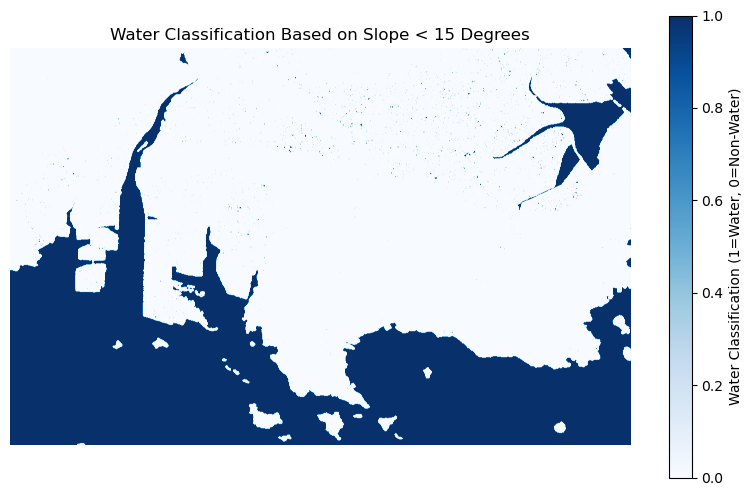

In [24]:
import numpy as np
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt

def resample_raster(source_raster, target_raster_shape, target_transform, target_crs):
    # Create an empty array for the resampled slope data
    resampled_raster = np.empty(target_raster_shape, dtype=source_raster.dtype)
    
    # Perform the reprojection/resampling
    with rasterio.Env():
        reproject(
            source=source_raster,
            destination=resampled_raster,
            src_transform=slope_src.transform,
            src_crs=slope_src.crs,
            dst_transform=target_transform,
            dst_crs=target_crs,
            resampling=Resampling.bilinear  # You can choose other resampling methods (e.g., nearest, cubic)
        )
    
    return resampled_raster

# Resample the slope data to match the water mask dimensions
with rasterio.open(slope_path) as slope_src:
    slope_resampled = resample_raster(
        slope_src.read(1),  # The slope data (first band)
        water_mask.shape,  # Target shape (same as water_mask)
        transform,  # The transform of the water mask
        profile['crs']  # The CRS of the water mask
    )

# Classify based on slope threshold (<15 degrees for water, >=15 degrees for non-water)
water_classification15 = np.where(slope_resampled < 15, 1, 0).astype(np.uint8)  # 1 for water, 0 for non-water, and set dtype to uint8

# Optionally, combine this classification with a water mask filter if you want to refine results
# water_mask_filtered = (water_mask == 1)  # Assuming water_mask is binary
# water_classification = np.where(water_mask_filtered, water_classification, np.nan)

# Plot the classified water and non-water areas
plt.figure(figsize=(10, 6))
plt.imshow(water_classification, cmap='Blues')  # Blue for water, white for non-water
plt.colorbar(label='Water Classification (1=Water, 0=Non-Water)')
plt.title('Water Classification Based on Slope < 15 Degrees')
plt.axis('off')
plt.show()

In [25]:
# Assuming roi is defined as a bounding box: (min_lon, min_lat, max_lon, max_lat)
roi = [133.6341032752386866, 34.4100997954243155, 133.9596877832316864, 34.6186143745820587]
##roi = [102.0000000000000000,0.0000000000000000, 103.0000000000000000,1.0000000000000000]

# Calculate the midpoint latitude of the ROI
latitude = (roi[1] + roi[3]) / 2  # (min_lat + max_lat) / 2

# Use the latitude to calculate the conversion factor from degrees to meters
meters_per_degree = 111320 * np.cos(np.radians(latitude))  # Adjust based on latitude

pixel_width_deg = abs(profile['transform'][0])
pixel_height_deg = abs(profile['transform'][4])

# Convert pixel dimensions from degrees to meters
pixel_width_m = pixel_width_deg * meters_per_degree
pixel_height_m = pixel_height_deg * meters_per_degree

# Calculate pixel area in square meters
pixel_area = pixel_width_m * pixel_height_m
print(f"Pixel area (in square meters): {pixel_area:.2f}")

# Calculate the area covered by water in hectares
water_area_ha = np.sum(water_classification15) * pixel_area / 10000  # convert to hectares
print(f'Water Area: {water_area_ha:.2f} hectares')

Pixel area (in square meters): 5.15
Water Area: 19033.23 hectares


In [26]:
import numpy as np
import rasterio
from rasterio.transform import from_origin


# Export the classified water data as a GeoTIFF
output_path = "/home/jovyan/shared/Arissara/ALOS-2/hands-on/test/15degree_water_classification.tif"

# Open a new file to write the GeoTIFF
with rasterio.open(
    output_path,
    'w',
    driver='GTiff',
    height=water_classification.shape[0],
    width=water_classification.shape[1],
    count=1,  # Number of bands
    dtype=water_classification.dtype,  # Ensure correct dtype
    crs=profile['crs'],  # Use the CRS from the original raster (this is critical for QGIS)
    transform=transform,  # Use the transform from the original raster
    compress='lzw',  # Optional: Compress to reduce file size, can be removed if not needed
    nodata=255  # Define nodata value, for areas without data, you can adjust this value as needed
) as dst:
    dst.write(water_classification, 1)  # Write the classification array to the first band
    dst.update_tags(1, description="Water classification (1=water, 0=non-water)")

print(f"Water classification has been exported to {output_path}")

Water classification has been exported to /home/jovyan/shared/Arissara/ALOS-2/hands-on/test/15degree_water_classification.tif


### Summary

The result of using slope threshold <5 degrees for water, >=5 degrees for non-water is **better** than using slope threshold <10 degrees and <15 degrees for water area.

Classifying water and non-water areas based on **slope threshold** helps improve the accuracy of distinguishing between these surfaces in topographically complex regions, like mountainous or hilly terrain. Water bodies are generally found on flat or gently sloping areas, while non-water surfaces are more likely to occur on steeper slopes.

#### Why a Slope Threshold < 5° is Better:
- **Water Behavior**: Water typically accumulates and spreads over flat surfaces. A lower slope threshold (e.g., **< 5 degrees**) more accurately captures flat or near-flat areas where water bodies are likely to exist.
- **Precision**: A threshold of **5°** offers a more precise separation between water and non-water compared to higher thresholds. Using higher thresholds, like **10°** or **15°**, may misclassify slightly sloping non-water areas (e.g., hilly , shadow of the mountainland) as water, reducing classification accuracy.
- **Steeper Thresholds Increase Errors**: At thresholds like **10°** or **15°**, the classifier may include sloped terrains as water, leading to overestimation of water areas and misclassification of non-water regions in hilly or mountainous environments.

Thus, using a slope threshold of **< 5 degrees** for water and **≥ 5 degrees** for non-water provides a more reliable and accurate classification in rugged landscapes.

## Convert raster to vector

In [34]:
pip install geopandas

  Using cached geopandas-1.0.1-py3-none-any.whl.metadata (2.2 kB)
  Using cached pyogrio-0.9.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.8 kB)
  Using cached pyproj-3.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (31 kB)
  Using cached shapely-2.0.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.0 kB)
Using cached geopandas-1.0.1-py3-none-any.whl (323 kB)
Using cached pyogrio-0.9.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (23.3 MB)
Using cached pyproj-3.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.6 MB)
Using cached shapely-2.0.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.5 MB)
Note: you may need to restart the kernel to use updated packages.


In [35]:
from rasterio.features import shapes
import geopandas as gpd
from shapely.geometry import shape
import numpy as np

In [36]:
# Path to the input raster file
input_raster = '/home/jovyan/shared/Arissara/ALOS-2/hands-on/test/5degree_water_classification.tif'
output_vector = '/home/jovyan/shared/Arissara/ALOS-2/hands-on/test/5degree_water_classification.gpkg'  # You can change to .geojson or .gpkg

In [37]:
# Open the raster file using rasterio
with rasterio.open(input_raster) as src:
    # Read the first band (or all bands depending on your needs)
    raster = src.read(1)
    
    # Get the affine transform to preserve the spatial coordinates
    transform = src.transform
    
    # Get the coordinate reference system (CRS)
    crs = src.crs

# Optional: Threshold the raster (e.g., binary mask)
# This is only required if you want to extract certain areas based on the raster values
binary_raster = raster > 0  # Example threshold, adjust based on your data

# Vectorize the raster using rasterio.features.shapes to generate polygons
results = (
    {'properties': {'value': v}, 'geometry': shape(s)}
    for s, v in shapes(binary_raster.astype(np.int16), transform=transform)
)

# Convert the result to a GeoDataFrame (which supports geospatial vector data)
geoms = list(results)
gdf = gpd.GeoDataFrame.from_features(geoms, crs=crs.to_string())  # Set CRS to match the raster

# Save the vectorized output to a file (Shapefile, GeoJSON, GPKG)
gdf.to_file(output_vector, driver="GPKG")  # You can change the format here

# Optionally, display a summary of the vector data
print(gdf.head())

                                            geometry  value
0  POLYGON ((133.65276 34.61864, 133.65276 34.618...    1.0
1  POLYGON ((133.66055 34.61864, 133.66055 34.618...    1.0
2  POLYGON ((133.66305 34.61864, 133.66305 34.618...    1.0
3  POLYGON ((133.6697 34.61864, 133.6697 34.61861...    1.0
4  POLYGON ((133.68442 34.61864, 133.68442 34.618...    1.0


### Appendix

Download sample data from 
- [ALOS-2 / PALSAR-2 Sample Product](https://www.eorc.jaxa.jp/ALOS/en/alos-2/datause/a2_sample_e.htm)
- [PALSAR 10m Mosaic Data](https://www.eorc.jaxa.jp/ALOS/en/dataset/fnf/pal_10m_mosaic_e.htm)